In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Matplotlib is building the font cache; this may take a moment.
/Users/ninad/Projects/RBCSolveit/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [28]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to your image directory and metadata file
IMAGE_DIR = './ISIC-images'
METADATA_PATH = './ISIC-images/metadata.csv'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [29]:
# Load metadata
print("[INFO] Loading metadata...")
metadata = pd.read_csv(METADATA_PATH)
print(f"Total records: {len(metadata)}")

# Display a sample of the data
print("Sample of metadata:")
metadata.head()

[INFO] Loading metadata...
Total records: 2550
Sample of metadata:


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,anatom_site_special,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,...,image_type,lesion_id,mel_class,mel_thick_mm,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,sex
0,ISIC_0009868,Anonymous,CC-0,NaN,70,posterior torso,NaN,malignant,4.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,female
1,ISIC_0009869,Anonymous,CC-0,NaN,40,posterior torso,NaN,benign,4.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,True,female
2,ISIC_0009870,Anonymous,CC-0,NaN,40,upper extremity,NaN,benign,3.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,True,female
3,ISIC_0009871,Anonymous,CC-0,NaN,45,posterior torso,NaN,benign,5.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,male
4,ISIC_0009872,Anonymous,CC-0,NaN,50,head/neck,NaN,benign,3.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,female


In [30]:
metadata.columns

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'anatom_site_special',
       'benign_malignant', 'clin_size_long_diam_mm', 'concomitant_biopsy',
       'dermoscopic_type', 'diagnosis', 'diagnosis_1', 'diagnosis_2',
       'diagnosis_3', 'diagnosis_4', 'diagnosis_5', 'diagnosis_confirm_type',
       'family_hx_mm', 'fitzpatrick_skin_type', 'image_type', 'lesion_id',
       'mel_class', 'mel_thick_mm', 'mel_ulcer', 'melanocytic', 'nevus_type',
       'patient_id', 'personal_hx_mm', 'sex'],
      dtype='object')

In [31]:
# Display target distribution
print("\nTarget distribution:")
print(metadata['benign_malignant'].value_counts())

# Check for missing values
print("\nMissing values per column:")
print(metadata.isnull().sum())


Target distribution:
benign_malignant
benign                     2015
malignant                   468
indeterminate/benign         33
indeterminate/malignant      21
indeterminate                 9
Name: count, dtype: int64

Missing values per column:
isic_id                      0
attribution                  0
copyright_license            0
acquisition_day           1613
age_approx                   0
anatom_site_general          0
anatom_site_special       2537
benign_malignant             4
clin_size_long_diam_mm       0
concomitant_biopsy          26
dermoscopic_type          1695
diagnosis                  359
diagnosis_1                  1
diagnosis_2                333
diagnosis_3                372
diagnosis_4               1320
diagnosis_5               1945
diagnosis_confirm_type       5
family_hx_mm                 0
fitzpatrick_skin_type     1924
image_type                   0
lesion_id                 1613
mel_class                 2455
mel_thick_mm              2504
mel

In [32]:
metadata.isnull().sum()

isic_id                      0
attribution                  0
copyright_license            0
acquisition_day           1613
age_approx                   0
anatom_site_general          0
anatom_site_special       2537
benign_malignant             4
clin_size_long_diam_mm       0
concomitant_biopsy          26
dermoscopic_type          1695
diagnosis                  359
diagnosis_1                  1
diagnosis_2                333
diagnosis_3                372
diagnosis_4               1320
diagnosis_5               1945
diagnosis_confirm_type       5
family_hx_mm                 0
fitzpatrick_skin_type     1924
image_type                   0
lesion_id                 1613
mel_class                 2455
mel_thick_mm              2504
mel_ulcer                 2510
melanocytic                358
nevus_type                2542
patient_id                1613
personal_hx_mm               1
sex                          0
dtype: int64

In [36]:
# Function to analyze correlations between features and target
def analyze_feature_correlations(df, target_col='benign_malignant'):
    """Analyze correlations between features and target."""
    # Make a copy of the DataFrame
    analysis_df = df.copy()
    
    # Handle missing values for analysis
    for col in analysis_df.select_dtypes(include=['float64', 'int64']).columns:
        analysis_df[col] = analysis_df[col].fillna(analysis_df[col].median())
    
    for col in analysis_df.select_dtypes(include=['object']).columns:
        analysis_df[col] = analysis_df[col].fillna(analysis_df[col].mode()[0])
    
    # Encode target variable
    le = LabelEncoder()
    analysis_df['target_encoded'] = le.fit_transform(analysis_df[target_col])
    
    # Analyze numeric features
    numeric_cols = ['age_approx', 'clin_size_long_diam_mm']
    numeric_df = analysis_df[numeric_cols + ['target_encoded']].copy()
    numeric_corr = numeric_df.corr()['target_encoded'].sort_values(ascending=False)
    
    # Analyze categorical features
    categorical_cols = ['anatom_site_general', 'sex', 'fitzpatrick_skin_type', 'melanocytic']
    categorical_corrs = []
    
    for col in categorical_cols:
        if col in analysis_df.columns:
            # Create dummy variables
            dummies = pd.get_dummies(analysis_df[col], prefix=col)
            # Merge with target
            merged = pd.concat([dummies, analysis_df['target_encoded']], axis=1)
            # Calculate correlations
            corr = merged.corr()['target_encoded'].drop('target_encoded')
            categorical_corrs.append(corr)
    
    return numeric_corr, categorical_corrs

# Run correlation analysis
print("\n[INFO] Analyzing feature correlations...")
numeric_corr, categorical_corrs = analyze_feature_correlations(metadata)

print("\nNumeric feature correlations:")
print(numeric_corr)

print("\nTop categorical feature correlations:")
for i, corr in enumerate(categorical_corrs):
    print(f"\nCategory {i+1}:")
    print(corr.sort_values(ascending=False).head(3))

# Based on correlation analysis, select features for the MLP branch
selected_features = ['anatom_site_general', 'dermoscopic_type', 'fitzpatrick_skin_type', 'sex', 'age_approx', 'clin_size_long_diam_mm']
print(f"\nSelected features for MLP branch: {selected_features}")


[INFO] Analyzing feature correlations...

Numeric feature correlations:
target_encoded            1.000000
age_approx                0.341762
clin_size_long_diam_mm    0.294884
Name: target_encoded, dtype: float64

Top categorical feature correlations:

Category 1:
anatom_site_general_head/neck          0.172671
anatom_site_general_upper extremity    0.064013
anatom_site_general_palms/soles       -0.007914
Name: target_encoded, dtype: float64

Category 2:
sex_male      0.120135
sex_female   -0.120135
Name: target_encoded, dtype: float64

Category 3:
fitzpatrick_skin_type_I     0.081510
fitzpatrick_skin_type_II    0.004840
fitzpatrick_skin_type_IV   -0.021207
Name: target_encoded, dtype: float64

Category 4:
melanocytic_True     0.021798
melanocytic_False   -0.021798
Name: target_encoded, dtype: float64

Selected features for MLP branch: ['anatom_site_general', 'dermoscopic_type', 'fitzpatrick_skin_type', 'sex', 'age_approx', 'clin_size_long_diam_mm']


/var/folders/kw/fxbbvv5x7lvct1l7rdc18tkw0000gn/T/ipykernel_36606/3358278318.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  analysis_df[col] = analysis_df[col].fillna(analysis_df[col].mode()[0])


In [37]:
# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """Load and preprocess an image for the CNN branch."""
    try:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        # Return a blank image if there's an error
        return np.zeros((target_size[0], target_size[1], 3))

# Function to preprocess metadata for MLP branch
def preprocess_metadata(df, selected_features, target_col='benign_malignant'):
    """Preprocess metadata for the MLP branch."""
    # Drop rows with missing target or missing isic_id
    df = df.dropna(subset=[target_col, 'isic_id'])
    
    # Create a copy with only the selected features and target
    df_selected = df[selected_features + [target_col]].copy()
    
    # Split features and target
    X = df_selected.drop(columns=[target_col])
    y = df_selected[target_col]
    
    # Encode target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ],
        remainder='drop'
    )
    
    # Fit and transform
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed, y_encoded, preprocessor, le, df['isic_id'].values

In [38]:

# Preprocess metadata
print("\n[INFO] Preprocessing metadata...")
X_meta, y, preprocessor, label_encoder, isic_ids = preprocess_metadata(metadata, selected_features)
print(f"Metadata shape after preprocessing: {X_meta.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Create image paths
image_paths = [os.path.join(IMAGE_DIR, f"{id}.jpg") for id in isic_ids]

# Split data into train and test sets
print("\n[INFO] Splitting data into train and test sets...")
X_meta_train, X_meta_test, X_img_paths_train, X_img_paths_test, y_train, y_test = train_test_split(
    X_meta, image_paths, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_meta_train)}")
print(f"Test set size: {len(X_meta_test)}")


[INFO] Preprocessing metadata...
Metadata shape after preprocessing: (2546, 18)
Number of classes: 5

[INFO] Splitting data into train and test sets...
Training set size: 2036
Test set size: 510


In [40]:
# For demonstration, limit the number of images to load (adjust based on your memory)
MAX_IMAGES = 1000  # Adjust as needed
if len(X_img_paths_train) > MAX_IMAGES:
    print(f"\n[INFO] Limiting training set to {MAX_IMAGES} images for memory constraints")
    indices = np.random.choice(len(X_img_paths_train), MAX_IMAGES, replace=False)
    X_img_paths_train = [X_img_paths_train[i] for i in indices]
    X_meta_train = X_meta_train[indices]
    y_train = y_train[indices]

if len(X_img_paths_test) > MAX_IMAGES // 5:
    test_size = MAX_IMAGES // 5
    print(f"[INFO] Limiting test set to {test_size} images")
    indices = np.random.choice(len(X_img_paths_test), test_size, replace=False)
    X_img_paths_test = [X_img_paths_test[i] for i in indices]
    X_meta_test = X_meta_test[indices]
    y_test = y_test[indices]

# Load images
print("\n[INFO] Loading images...")
X_img_train = np.array([load_and_preprocess_image(path) for path in X_img_paths_train])
X_img_test = np.array([load_and_preprocess_image(path) for path in X_img_paths_test])

print(f"Image data shape: {X_img_train.shape}")
print(f"Metadata shape: {X_meta_train.shape}")


[INFO] Limiting training set to 1000 images for memory constraints
[INFO] Limiting test set to 200 images

[INFO] Loading images...
Image data shape: (1000, 224, 224, 3)
Metadata shape: (1000, 18)


In [41]:
# Define CNN branch (for images)
def create_cnn_branch(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    """Create CNN branch for image data."""
    # Use a pre-trained model as the base
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the CNN branch
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    return inputs, x

# Define MLP branch (for metadata)
def create_mlp_branch(input_dim):
    """Create MLP branch for metadata."""
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return inputs, x

# Create the mixed input model
def create_mixed_input_model(img_shape=(IMG_WIDTH, IMG_HEIGHT, 3), meta_dim=None, num_classes=2):
    """Create a model with both CNN and MLP branches."""
    # Create branches
    img_input, cnn_output = create_cnn_branch(img_shape)
    meta_input, mlp_output = create_mlp_branch(meta_dim)
    
    # Combine branches
    combined = Concatenate()([cnn_output, mlp_output])
    
    # Add final layers
    x = Dense(128, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Add output layer based on number of classes
    if num_classes == 2:
        output = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        output = Dense(num_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
    
    # Create model
    model = Model(inputs=[img_input, meta_input], outputs=output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [42]:
# Create the model
print("\n[INFO] Creating mixed input model...")
num_classes = len(np.unique(y))
meta_dim = X_meta_train.shape[1]
mixed_model = create_mixed_input_model(meta_dim=meta_dim, num_classes=num_classes)

# Print model summary
mixed_model.summary()


[INFO] Creating mixed input model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      2,432 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_4[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     41,088 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        645 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,639,621 (10.07 MB)

 Trainable params: 380,997 (1.45 MB)

 Non-trainable params: 2,258,624 (8.62 MB)

In [43]:
# Set up callbacks
checkpoint = ModelCheckpoint(
    'skin_lesion_classifier',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("\n[INFO] Training model...")
history = mixed_model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_meta_test], y_test),
    batch_size=32,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)


[INFO] Training model...
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.2329 - loss: 2.4676
Epoch 1: val_accuracy improved from -inf to 0.40500, saving model to skin_lesion_classifier.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2338 - loss: 2.4624 - val_accuracy: 0.4050 - val_loss: 1.3714
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.3778 - loss: 1.8678
Epoch 2: val_accuracy improved from 0.40500 to 0.78500, saving model to skin_lesion_classifier.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1000ms/step - accuracy: 0.3782 - loss: 1.8662 - val_accuracy: 0.7850 - val_loss: 0.9319
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.4870 - loss: 1.5274
Epoch 3: val_accuracy improved from 0.78500 to 0.86000, saving model to skin_lesion_classifier.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 998ms/step - accuracy: 0.4880 - loss: 1.5244 - val_accuracy: 0.8600 - val_loss: 0.6540
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.5726 - loss: 1.2901
Epoch 4: val_accuracy did not improve from 0.86000
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5729 - loss: 1.2885 - val_accuracy: 0.8350 - val_loss: 0.6018
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.6645 - loss: 1.0427
Epoch 5: val_accuracy did not improve from 0.86000
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6650 - loss: 1.0419 - val_accuracy: 0.8350 - val_loss: 0.5821
Restoring model weights from the end of the best epoch: 3.


In [45]:
# Evaluate model
print("\n[INFO] Evaluating model...")
evaluation = mixed_model.evaluate([X_img_test, X_meta_test], y_test)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))


[INFO] Evaluating model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 999ms/step - accuracy: 0.8774 - loss: 0.6138
Test Loss: 0.6540
Test Accuracy: 0.8600


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

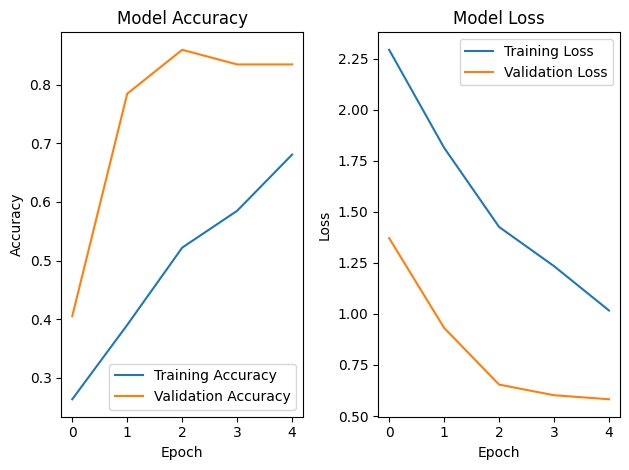

In [46]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [47]:
# Make predictions on a few examples
print("\n[INFO] Making predictions on test examples...")
predictions = mixed_model.predict([X_img_test[:5], X_meta_test[:5]])

# Display results
for i in range(5):
    true_label = "Malignant" if y_test[i] == 1 else "Benign"
    if num_classes == 2:
        pred_prob = predictions[i][0]
        pred_label = "Malignant" if pred_prob > 0.5 else "Benign"
        print(f"Example {i+1}: True: {true_label}, Predicted: {pred_label} (Probability: {pred_prob:.4f})")
    else:
        pred_class = np.argmax(predictions[i])
        pred_label = label_encoder.inverse_transform([pred_class])[0]
        print(f"Example {i+1}: True: {true_label}, Predicted: {pred_label}")


[INFO] Making predictions on test examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Example 1: True: Benign, Predicted: benign
Example 2: True: Benign, Predicted: benign
Example 3: True: Benign, Predicted: benign
Example 4: True: Benign, Predicted: benign
Example 5: True: Benign, Predicted: benign
